In [2]:
# core
import os, pickle, json, shutil, math
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image
import cv2
from PIL import Image, ImageFile

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

from threading import Thread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.vgg19 import VGG19


tqdm.pandas()
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

### 라벨 정보

In [3]:
label2idx = {'레트로': 0,
 '로맨틱': 1,
 '리조트': 2,
 '매니시': 3,
 '모던': 4,
 '밀리터리': 5,
 '섹시': 6,
 '소피스트케이티드': 7,
 '스트리트': 8,
 '스포티': 9,
 '아방가르드': 10,
 '오리엔탈': 11,
 '웨스턴': 12,
 '젠더리스': 13,
 '컨트리': 14,
 '클래식': 15,
 '키치': 16,
 '톰보이': 17,
 '펑크': 18,
 '페미닌': 19,
 '프레피': 20,
 '히피': 21,
 '힙합': 22}

### 모델 불러오기

In [4]:
# 모델 불러오기
model = tf.keras.models.load_model('./vgg19_full_freeze_dropout05.h5')

OSError: No file or directory found at ./VGG19_model.h5

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 23)                23575 

### Test(Inference) 데이터셋 불러오기

In [5]:
class TestDataset(tf.keras.utils.Sequence):
    def __init__(self, root, transform=None):
        self.root = root
        self.image_list = os.listdir(root)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.image_list[index])
        image = tf.keras.preprocessing.image.load_img(image_path)
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = self.transform(image)
        return self.image_list[index], image

In [8]:
test_transform = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.convert_image_dtype(x, dtype=tf.float32)),
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=(224, 224))),
    tf.keras.layers.Lambda(lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225])
])

In [13]:
# Inference용 데이터셋 불러오기
batch_size = 1
inference_path = './real_data/' # real img가 담길 경로

test_dataset = TestDataset(inference_path, transform=test_transform)
test_dataloader = tf.data.Dataset.from_generator(
    lambda: test_dataset,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)
    )
).batch(batch_size) # 여기서 batch_size만큼 뭉텅이로 데이터 불러옴

### mean_img 불러오기

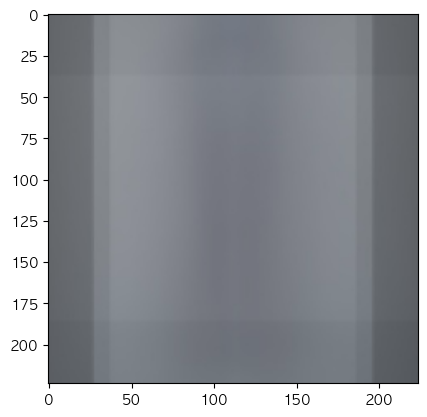

In [14]:
mean_img_path = './mean_img.jpg'
mean_img = cv2.imread(mean_img_path)

plt.imshow(mean_img)

### Inference

In [15]:
# inference
result = []

for fnames, data in tqdm(test_dataloader):
    data = data.numpy()
    output = model.predict(data-mean_img)
    pred = np.argmax(output, axis=1)

    for j in range(len(fnames)):
        result.append({
            'filename': fnames[j].numpy().decode('utf-8'),
            'style': pred[j]
        })
    break
        
result

0it [00:00, ?it/s]2023-07-12 21:49:41.353655: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 307ms/step


0it [00:00, ?it/s]


[{'filename': 'KF_TEST_002713.jpg', 'style': 7},
 {'filename': 'KF_TEST_002712.jpg', 'style': 5},
 {'filename': 'KF_TEST_002715.jpg', 'style': 2},
 {'filename': 'KF_TEST_002714.jpg', 'style': 3}]